# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

# Lab 9: Decision Trees and Bagging

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai<br/>
**Lab Team**: Marios Mattheakis, Hayden Joy, Chris Gumb, and Eleni Kaxiras<br/>
**Authors**: Hayden Joy, and Marios Mattheakis
<hr style='height:2px'>

In [8]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

This lab will work with a spam email dataset. Our ultimate goal is to be able to build models so that we can predict whether an email is spam or not spam based on word characteristics within each email. We will cover Decision Trees and Bagging methods and allow you to apply it to the homework.

Specifically, we will: 
    
    1. Load in the spam dataset and split the data into train and test.
    2. Find the optimal depth for the Decision Tree model and evaluate performance.
    3. Fit the Bagging model using multiple bootstrapped datasets and do majority voting. 
    
Hopefully after this lab you will be able to answer the following questions: 
 - What are decision tree models?
 - How do we construct them?
 - How do we visualize them?
 - What is bagging?
 - Why does bagging help with overfitting?
 - Why does bagging help to built more expressive trees?

---------

#### The Idea: Decision Trees are just flowcharts and are interpretable!

<img src="./flowchart.png" alt="how to fix anything" width="70%"/>


It turns out that simple flow charts can be formulated as mathematical models for classification and these models have the properties we desire;
 - interpretable by humans 
 - have sufficiently complex decision boundaries 
 - the decision boundaries are locally linear, each component of the decision boundary is simple to describe mathematically. 


----------

#### Let's review some theory: 

#### How to build Decision Trees (the Learning Algorithm in words): 
To learn a decision tree model, we take a greedy approach: 
 1. Start with an empty decision tree (undivided feature space) 
 2. Choose the ‘optimal’ predictor on which to split and choose the ‘optimal’ threshold value for splitting by applying a **splitting criterion (1)**
 3. Recurse on on each new node until **stopping condition (2)** is met
 
For classification, we label each region in the model with the label of the class to which the majority of the points within the region belong. 

#### So we need a (1) splitting criterion and a (2) stopping condition:

  #### (1) Splitting criterion 
<img src="./split1.png" alt="split1" width="70%"/>

---
<img src="./split2.png" alt="split2" width="70%"/>

<img src="./simple_tree.png" alt="tree_adj" width="39%"/>
<img src="./tree_loss.png" alt="tree_adj" width="39%"/>

#### (2) Stopping condition

If we don’t terminate the decision tree learning algorithm manually, the tree will continue to grow until each region defined by the model possibly contains exactly one training point (and the model attains 100% training accuracy). **Not stopping while building a deeper and deeper tree = 100% training accuracy; What will your test accuracy be? What can we do to fix this?**

To prevent the **overfitting** from happening, we could 
- Stop the algorithm at a particular depth. (=**not too deep**)
- Don't split a region if all instances in the region belong to the same class. (=**stop when subtree is pure**)
- Don't split a region if the number of instances in the sub-region will fall below pre-defined threshold (min_samples_leaf). (=**not too specific/small subtree**)
- Don't use too many splits in the tree (=**not too many splits / not too complex global tree**)
- Be content with <100% accuracy training set...

-------------

#### Done with theory, let's get started

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import datasets

#new model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import learning_curve


-------------

# Part 1 : Introduction to the Spam Dataset

We will be working with a spam email dataset. The dataset has 57 predictors with a response variable called `Spam` that indicates whether an email is spam or not spam. The goal is to be able to create a classifier or method that acts as a spam filter.

In [10]:
#Import Dataframe and Set Column Names
spam_df = pd.read_csv('./spam.csv', header=None)
columns = ["Feature_"+str(i+1) for i in range(spam_df.shape[1]-1)] + ['Spam']
spam_df.columns = columns
display(spam_df.head())
len(spam_df)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


4601

The predictors are all continuous. They represent certain features like the frequency of the word `'discount'`. The exact specification and description of each predictor can be found online. We are not so much interested in the exact inference of each predictor so we will omit the exact names of each of the predictors. We are more interested in the predictions of the algorithm so we will not go into detail about the individual features.

Link to description : https://archive.ics.uci.edu/ml/datasets/spambase

Let us split the dataset into a 70-30 split by using the following:

**Note :** While you will use ```train_test_split``` in your homeworks, the code below should help you visualize splitting/masking of a dataframe which will be helpful in general.

### Split data into train and test

In [11]:
np.random.seed(42)

#draw n samples from the uniform distribution
len((spam_df))
uniform_samples = np.random.rand(len(spam_df))

#create boolean mask
msk = uniform_samples < 0.7

In [12]:
#subset the combined design matrix / response dataframe with the boolean mask
data_train = spam_df[msk]
data_test  = spam_df[~msk]

#Split predictor and response columns
x_train, y_train = data_train.drop(['Spam'], axis=1), data_train['Spam']
x_test , y_test  = data_test.drop(['Spam'] , axis=1), data_test['Spam']

print("Shape of Training Set :",data_train.shape)
print("Shape of Testing Set :" ,data_test.shape)

Shape of Training Set : (3262, 58)
Shape of Testing Set : (1339, 58)


In [13]:
~msk*1

array([0, 1, 1, ..., 0, 0, 0])

In [14]:
assert True ==1
assert False == 0

In [15]:
x_train.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57
0,0.0,0.64,0.64,0.0,0.32,0.0,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.0,0.0,0.32,0.0,1.29,1.93,0.0,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.778,0.000,0.0,3.756,61,278
3,0.0,0.00,0.00,0.0,0.63,0.0,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.0,0.0,0.31,0.0,0.00,3.18,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137,0.0,0.137,0.000,0.0,3.537,40,191
4,0.0,0.00,0.00,0.0,0.63,0.0,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.0,0.0,0.31,0.0,0.00,3.18,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135,0.0,0.135,0.000,0.0,3.537,40,191
5,0.0,0.00,0.00,0.0,1.85,0.0,0.00,1.85,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223,0.0,0.000,0.000,0.0,3.000,15,54
6,0.0,0.00,0.00,0.0,1.92,0.0,0.00,0.00,0.00,0.64,0.96,1.28,0.00,0.0,0.0,0.96,0.0,0.32,3.85,0.0,0.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054,0.0,0.164,0.054,0.0,1.671,4,112


We can check that the number of spam cases is roughly evenly represented in both the training and test set.

In [16]:
#Check Percentage of Spam in Train and Test Set
pct_spam_tr = 100*y_train.mean()
pct_spam_te = 100*y_test.mean()
                                                  
print(f"Percentage of Spam in Training Set \t : {pct_spam_tr:0.2f}%")
print(f"Percentage of Spam in Testing Set \t : {pct_spam_te:0.2f}%")

Percentage of Spam in Training Set 	 : 39.18%
Percentage of Spam in Testing Set 	 : 39.96%


-----------

# Part 2 : Fitting an Optimal Single Decision Tree (by Depth) :

We fit here a single tree to our spam dataset and perform 5-fold cross validation on the training set. For ***each*** decision tree depth, we fit a tree and then compute the 5-fold CV scores. These scores are then averaged and compared across different depths. 

In [17]:
#Find optimal depth of trees
mean_CV_acc = {}
all_CV_acc = {}
tree_depth_start, tree_depth_end, steps = 3, 31, 4
for i in range(tree_depth_start, tree_depth_end + 1, steps):
    
    #declare tree model object
    model = DecisionTreeClassifier(max_depth=i)
    
    #get cv scores
    scores = cross_val_score(estimator=model, X=x_train, y=y_train, cv=5, n_jobs=-1)
    
    all_CV_acc[i] = scores
    mean_CV_acc[i] = scores.mean()

In [18]:
mean_CV_acc

{3: 0.8764437847029753,
 7: 0.8957600127772715,
 11: 0.8945339584174972,
 15: 0.8868718232978512,
 19: 0.8868732325557362,
 23: 0.8859548661674763,
 27: 0.8789024699593193,
 31: 0.8813498811525851}

Some dictionary manipulations for our x,y construction for the plot below:

In [19]:
x = list(mean_CV_acc.keys())
y = list(mean_CV_acc.values())
x,y

([3, 7, 11, 15, 19, 23, 27, 31],
 [0.8764437847029753,
  0.8957600127772715,
  0.8945339584174972,
  0.8868718232978512,
  0.8868732325557362,
  0.8859548661674763,
  0.8789024699593193,
  0.8813498811525851])

In [20]:
lists = sorted(mean_CV_acc.items())
x, y = zip(*lists)   
x,y

((3, 7, 11, 15, 19, 23, 27, 31),
 (0.8764437847029753,
  0.8957600127772715,
  0.8945339584174972,
  0.8868718232978512,
  0.8868732325557362,
  0.8859548661674763,
  0.8789024699593193,
  0.8813498811525851))

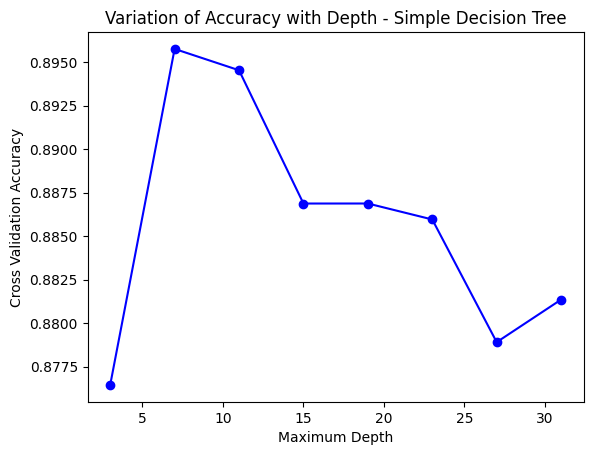

In [21]:
#Plot
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

As we can see, the optimal depth is found to be a depth of 7. Although, does it makes sense to choose 6?

Also, if we wanted to get the Confidence Bands of these results, how would we? It's as simple as a combination of getting variance using ```scores.std()``` and ```plt.fill_between()```.

In [22]:
stds = np.array([ np.std(scores) for scores in all_CV_acc.values() ])
stds

array([0.05181994, 0.0378903 , 0.04274894, 0.04986885, 0.0439699 ,
       0.04449062, 0.04735695, 0.04258144])

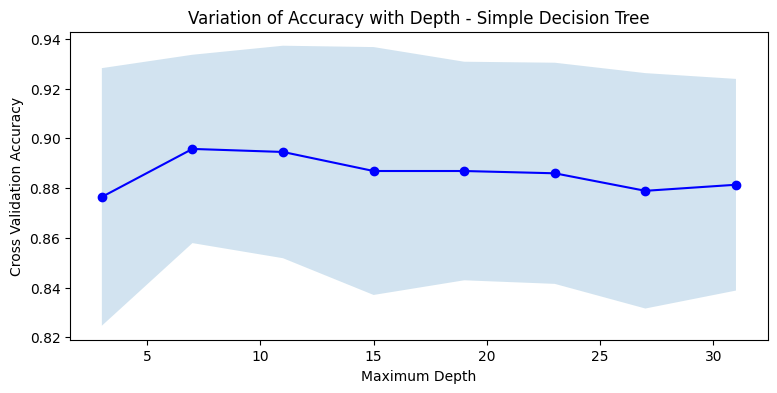

In [23]:
plt.figure(figsize = (9,4))
plt.fill_between(x, y + stds, y - stds, alpha=0.2)

#Plot
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

If we want to display it as a boxplot we first construct a dataframe with all the scores and second we use ```sns.boxplot(...)```

In [24]:
# Making a numpy array with all the CV acc scores
cv_scores_df = pd.DataFrame(all_CV_acc.values(), index = all_CV_acc.keys()).T
cv_scores_df

,3,7,11,15,19,23,27,31
0,0.915773,0.912711,0.912711,0.897397,0.900459,0.891271,0.885145,0.895865
1,0.877489,0.909648,0.906585,0.900459,0.892802,0.895865,0.892802,0.903522
2,0.904908,0.912577,0.907975,0.917178,0.911043,0.917178,0.901840,0.894172
3,0.907975,0.923313,0.934049,0.929448,0.927914,0.924847,0.926380,0.915644
4,0.776074,0.820552,0.811350,0.789877,0.802147,0.800613,0.788344,0.797546


In [25]:
#melt
trees = pd.melt(cv_scores_df, var_name = "Max Depth", value_name = 'CV Accuracy Score')
trees.head(10)

#this code achieves the same thing without pd.melt:
# Making a dataframe
# trees = pd.DataFrame({'Max Depth':list(x)*5, 'CV Accuracy Score': list(cv_scores_df.values.T.flatten())})
# trees.head()

,Max Depth,CV Accuracy Score
0,3,0.915773
1,3,0.877489
2,3,0.904908
3,3,0.907975
4,3,0.776074
5,7,0.912711
6,7,0.909648
7,7,0.912577
8,7,0.923313
9,7,0.820552


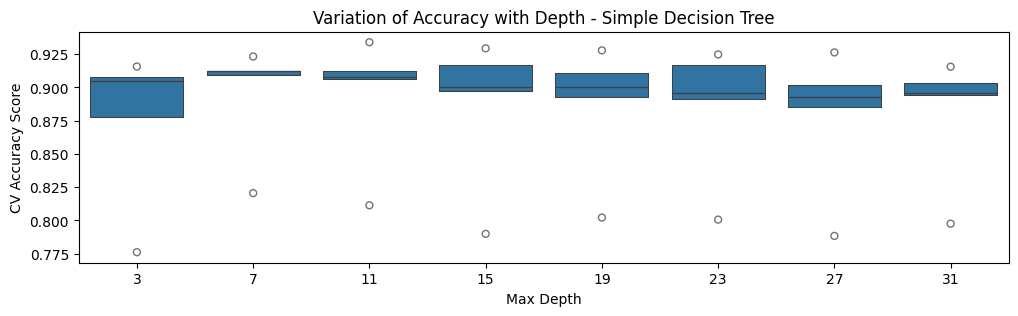

In [26]:
# plotting the boxplot 
plt.figure(figsize=(12, 3))
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
sns.boxenplot(x="Max Depth", y="CV Accuracy Score", data=trees);

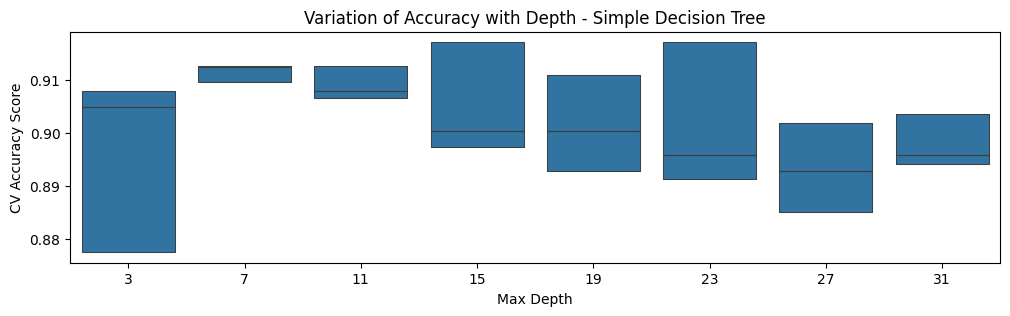

In [27]:
# plotting the boxplot without outliers (showfliers = False)
plt.figure(figsize=(12, 3))
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
sns.boxenplot(x="Max Depth", y="CV Accuracy Score", data=trees, showfliers=False);

**Let's extract the best_depth value from this dictionary:** 

We create the new variable ```best_depth```. Can you see why we coded the best depth parameter as we did below? (Hint: Think about reproducibility.)

How to sort using your own function with key parameter?
If you want your own implementation for sorting, sorted() also accepts a key function as an optional parameter.

Based on the results of the key function, you can sort the given iterable.

```sorted(iterable, key=len)```

In [28]:
# What does this do? Is this the result we want?
sorted(mean_CV_acc, reverse=False)

[3, 7, 11, 15, 19, 23, 27, 31]

In [29]:
# What does this do?
sorted(mean_CV_acc, key=mean_CV_acc.get, reverse=True)

[7, 11, 19, 15, 23, 31, 27, 3]

In [30]:
#Make best depth a variable
best_depth = sorted(mean_CV_acc, key=mean_CV_acc.get, reverse=True)[0]
print("The best depth was found to be:", best_depth)

The best depth was found to be: 7


In [31]:
#Evalaute the performance at the best depth
model_tree = DecisionTreeClassifier(max_depth=best_depth)
model_tree.fit(x_train, y_train)

#Check Accuracy of Spam Detection in Train and Test Set
acc_trees_training = accuracy_score(y_train, model_tree.predict(x_train))
acc_trees_testing  = accuracy_score(y_test,  model_tree.predict(x_test))

print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

Simple Decision Trees: Accuracy, Training Set 	 : 94.39%
Simple Decision Trees: Accuracy, Testing Set 	 : 90.81%


In [32]:
#Get Performance by Class (Lookup Confusion Matrix)
pd.crosstab(index    = y_test, 
            columns  = model_tree.predict(x_test), 
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins  = True)

Predicted,0,1,All
Actual,,,
0,758,46,804
1,77,458,535
All,835,504,1339


#### How to visualize a Decision Tree with ```pydot```

*Question:* Do you think this tree is interpretable? What do you think about a the maximal depth of the tree?

- Let's first store the decision tree in a text format: ```decision_tree.dot```

In [33]:
from sklearn import tree

file_name = "./decision_tree.dot"
tree.export_graphviz(model_tree, out_file = file_name) 

- Let's look at the resulting text ```decision_tree.dot```

In [34]:
! head ./decision_tree.dot 

digraph Tree {
node [shape=box, fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="x[52] <= 0.046\ngini = 0.477\nsamples = 3262\nvalue = [1984, 1278]"] ;
1 [label="x[6] <= 0.065\ngini = 0.354\nsamples = 2431\nvalue = [1872, 559]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="x[51] <= 0.491\ngini = 0.27\nsamples = 2209\nvalue = [1853, 356]"] ;
1 -> 2 ;
3 [label="x[15] <= 0.025\ngini = 0.186\nsamples = 1971\nvalue = [1767, 204]"] ;
2 -> 3 ;


- Let's convert our (hard to read) written decision tree (```decision_tree.dot```) into an intuitive image file format: ```image_tree.png```
- <span style="color:red">**NOTE:**</span> You might need to install the ```pydot``` package by typing the following command in your terminal: ```pip install pydot``` or you can install from within the jupyter notebook by running the following cell: ```! pip install pydot```

In [35]:
#! conda install pydot -y
#! conda install graphiv -y

In [36]:
import pydot
(graph,) = pydot.graph_from_dot_file(file_name)
graph.write_png('./image_tree.png')

- Let's display the ```image_tree.png``` in markdown:

Markdown: ```![title](./image_tree.png)```. The result: 

![title](./image_tree.png)

*Repost Question:* Do you think this tree is interpretable?


--------


<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 1:</strong> Implimenting Decision Trees </div>  


*Let's try out decision tree models on a cancer dataset. Click <a href = "https://towardsdatascience.com/building-a-simple-machine-learning-model-on-breast-cancer-data-eca4b3b99fa3">here </a> for another example with this dataset and more information.

This is a copy of UCI ML Breast Cancer Wisconsin (Diagnostic) datasets.

Features:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry 
- fractal dimension ("coastline approximation" - 1)

Target:
    2) Diagnosis (M = malignant, B = benign)

In [37]:
from functions import tree_pd
import numpy as np

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import datasets

%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import learning_curve

get_tree_scores = tree_pd.get_tree_scores
cancer_scaled, target = tree_pd.load_cancer_dataset(10, 4)

Design matrix shape (569, 10)


,texture error,worst texture,worst symmetry,compactness error,worst radius,worst compactness,concave points error,worst fractal dimension,fractal dimension error,mean radius
0,-0.565265,-1.359293,2.750622,1.316862,1.886690,2.616665,0.660820,1.937015,0.907083,1.097064
1,-0.876244,-0.369203,-0.243890,-0.692926,1.805927,-0.430444,0.260162,0.281190,-0.099444,1.829821
2,-0.780083,-0.023974,1.152255,0.814974,1.511870,1.082932,1.424827,0.201391,0.293559,1.579888
3,-0.110409,0.133984,6.046041,2.744280,-0.281464,3.893397,1.115007,4.935010,2.047511,-0.768909


target classes    {1: 'Benign', 0: 'Malignant'}
There are 357 Benign cases and 212 Malignant cases in the target


## Your tasks are as follows:

0) Perform a manual 80-20 train-test split

1) -4) see below


In [38]:
################################### Train Test split
np.random.seed(40)

#test_proportion
test_prop = 0.2

#sample from a random uniform distribution
uniform_samples = np.random.uniform(0, 1, target.size)

#create a boolean vector mask
msk = uniform_samples > test_prop

#Split predictor and response columns
x_train, y_train = cancer_scaled[msk], target[msk]
x_test , y_test  = cancer_scaled[~msk], target[~msk]

print("Shape of Training Set :", x_train.shape)
print("Shape of Testing Set :" , x_test.shape)

Shape of Training Set : (448, 10)
Shape of Testing Set : (121, 10)


In [39]:
# %load 'solutions/sol_tr_te_split.py'

1) Use the `get_tree_scores` function to assign a dataframe of cross-validation scores for different depths of a `DecisionTreeClassifier`. Specifically feed the function a class instance with `random_state=42`.  This function takes four arguments (x_train, y_train, model, tree_depth_range). This function returns a dictionary of scores.

2) use `pd.DataFrame` and `pd.melt` to assign a dataframe `cv_acc_df`. This dataframe should have two columns: `depth`  and `cv_acc_score`. Hint: check out the `var_name` and `value_name` arguments of `pd.melt`.

3) Visualize the mean cross validation accuracy scores using `sns.boxenplot` or another function of your choice similar to `sns.catplot`

4) Use pandas groupby function to to get the mean cross-validation accuracy for specific depths. Assign to a new dataframe `cv_acc_mean`.

5) Visualize the mean cross validation accuracy scores using `sns.lineplot` in combination with `cv_acc_mean`. Discuss what you see with your group.

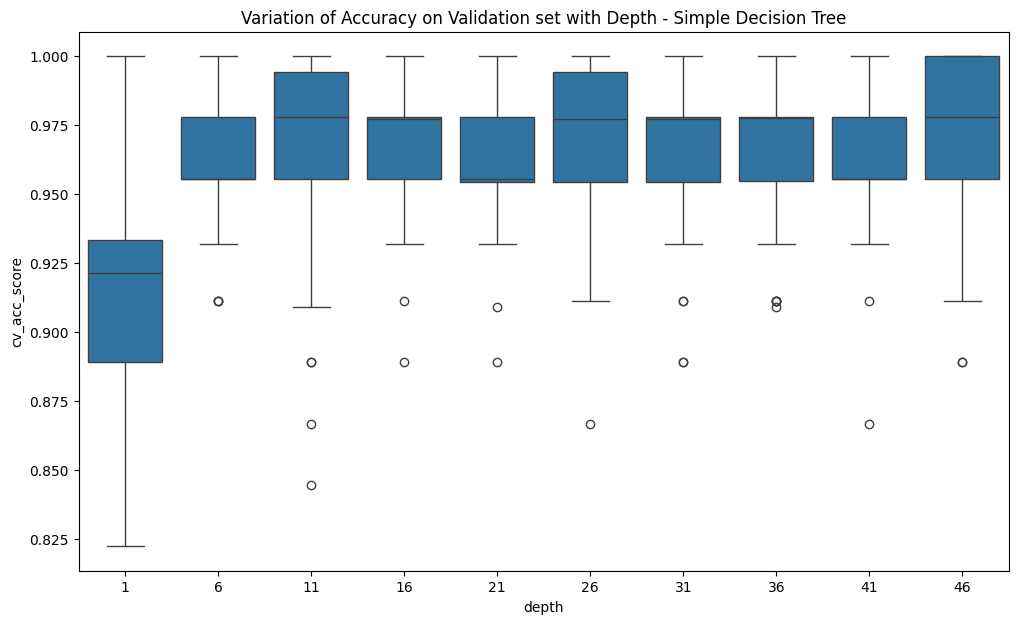

,cv_acc_score,depth
depth,,
1,0.918293,1
6,0.965242,6
11,0.966535,11
16,0.965667,16
21,0.963374,21


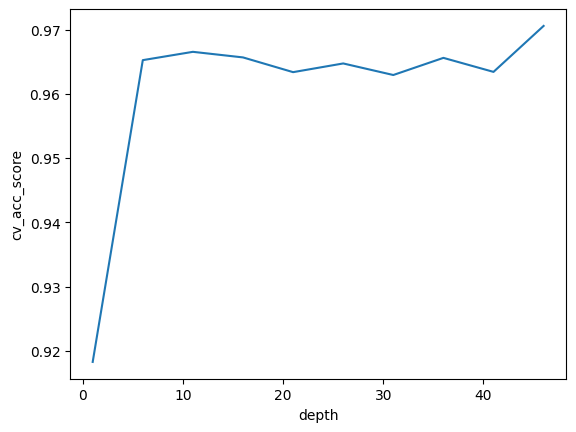

In [40]:
#your code here
tree_depth_range = range(1, 50, 5)
tree_scores = tree_pd.get_tree_scores(x_train,y_train, DecisionTreeClassifier(random_state=42), tree_depth_range, bootstraps=5)

cv_acc_df = pd.melt(pd.DataFrame(tree_scores), var_name="depth", value_name="cv_acc_score")


plt.figure(figsize=(12, 7))
plt.title('Variation of Accuracy on Validation set with Depth - Simple Decision Tree')
sns.boxplot(x="depth", y="cv_acc_score", data=cv_acc_df)
plt.show()

cv_acc_mean = cv_acc_df.groupby("depth").mean()
cv_acc_mean["depth"] = list(tree_depth_range)

sns.lineplot(x=cv_acc_mean.index, y=cv_acc_mean.cv_acc_score)

cv_acc_mean.head()


In [41]:
# %load 'solutions/sol1.py'

### once you have successfully completed the code above, this code should run without a problem.

In [42]:
max_idx = cv_acc_mean["cv_acc_score"].idxmax()
best_depth = cv_acc_mean["depth"][max_idx]
print("best depth {:}".format(best_depth))

model = DecisionTreeClassifier(max_depth=best_depth)
model.fit(x_train, y_train)

cancer_tree_accuracy = model.score(x_test, y_test)

print("Testing set accuracy {:.4f}".format(cancer_tree_accuracy))


best depth 46
Testing set accuracy 0.9174


Now answer the following questions:

$\bullet$ Why is the best depth the value that it is?

$\bullet$ Why might the deeper trees be over or under fitting on this particular dataset?

In [43]:
#TODO
tree.export_graphviz(model, "example_tree.dot")
import pydot
(graph,) = pydot.graph_from_dot_file("example_tree.dot")
graph.write_png('./small_tree.png')

### Try feeding the get_tree_pd an additional "bootstraps" argument and comment on what happens to the validation accuracy.

- Let's display the ```image_tree.png``` in markdown:

Markdown: ```![title](./small_tree.png)```. The result: 

![title](./small_tree2.png) 

*Repost Question:* Do you think this tree is interpretable?

In [44]:
# %load 'solutions/sol1_boot.py'


--------


# Part 3: Bagging and Voting

*QUESTION:* Where does the word *"Bagging"* come from?

#### Some Theory: What is bagging?
  1. Bootstrapping: resample with replacements to get different datasets and built different models.
  2. Do something smart to combine the different models.
  
One way to adjust for the high variance of the output of an experiment is to perform the experiment multiple times and then average the results. 

 1. **Bootstrap:** we generate multiple samples of training data, via bootstrapping. We train a full decision tree on each sample of data. 
 2. **AGgregatiING** for a given input, we output the averaged outputs of all the models for that input. 
 
This method is called **Bagging: B** ootstrap + **AGG**regat**ING**. 

-----------

Let's bootstrap our training dataset to create multiple datasets and fit Decision Tree models to each.

(Resampling: we showed live that different samples give different results for things like sums, varying more when the things we sum over have high variance themselves.)


<img src="./bagging_array.png" alt="tree_adj" width="80%"/>

In [45]:
# Stat on all data
data_train.mean(axis=0).to_frame('mean').T

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57,Spam
mean,0.105984,0.206603,0.284908,0.06607,0.309537,0.096462,0.11218,0.110368,0.088734,0.243182,0.062624,0.537961,0.096045,0.056395,0.049942,0.265929,0.139779,0.188832,1.691186,0.097235,0.81599,0.120224,0.097961,0.088694,0.528384,0.256327,0.776444,0.128697,0.097863,0.110806,0.064712,0.050377,0.102446,0.050635,0.112554,0.102541,0.135935,0.014834,0.081824,0.06897,0.039641,0.123467,0.045371,0.072471,0.308231,0.182955,0.005607,0.03191,0.036318,0.141634,0.018758,0.277636,0.071341,0.051376,5.300716,52.760883,278.253525,0.391784


In [46]:
x_train, y_train = data_train.drop(['Spam'], axis=1), data_train['Spam']
x_test , y_test  = data_test.drop(['Spam'] , axis=1), data_test['Spam']

In [47]:
data_train.sample(frac=1., replace=True).mean(axis=0).to_frame('mean').T

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57,Spam
mean,0.102094,0.210999,0.290098,0.071652,0.311683,0.091898,0.109074,0.107376,0.085153,0.237259,0.062091,0.517327,0.103967,0.063642,0.048906,0.26981,0.14591,0.188716,1.692075,0.102952,0.805999,0.095524,0.100236,0.098581,0.472357,0.226499,0.775457,0.112498,0.080898,0.090739,0.051064,0.039795,0.11366,0.0397,0.092781,0.087949,0.121993,0.013789,0.071916,0.057391,0.034335,0.121392,0.039298,0.073896,0.30466,0.177667,0.005635,0.026045,0.034336,0.134724,0.017294,0.28992,0.073148,0.055564,4.590368,54.293991,287.327406,0.397609


Now we actually fit the samples

In [48]:
n_trees = 100 # we tried a variety of numbers here
choosen_depth = 5

In [49]:
#Creating model
np.random.seed(0)
model = DecisionTreeClassifier(max_depth=choosen_depth)

#Initializing variables
predictions_train = np.zeros( shape = (data_train.shape[0], n_trees))
predictions_test  = np.zeros( shape = (data_test.shape[0],  n_trees))

#Conduct bootstraping iterations
for i in range(n_trees):
    temp = data_train.sample(frac=1, replace=True)
    boot_y = temp['Spam']
    boot_X = temp.drop(['Spam'], axis=1)
    
    model.fit(boot_X, boot_y)  
    predictions_train[:,i] = model.predict(x_train)   
    predictions_test[:,i] = model.predict(x_test)
    
#Make Predictions Dataframe
columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
predictions_train = pd.DataFrame(predictions_train, columns=columns)
predictions_test = pd.DataFrame(predictions_test, columns=columns)

In [50]:
y_train = data_train['Spam'].values
y_test = data_test['Spam'].values

In [51]:
## Example Bolean for locating the Non Spam
y == 0
## Example Bolean for locating the Spam
y == 1

False

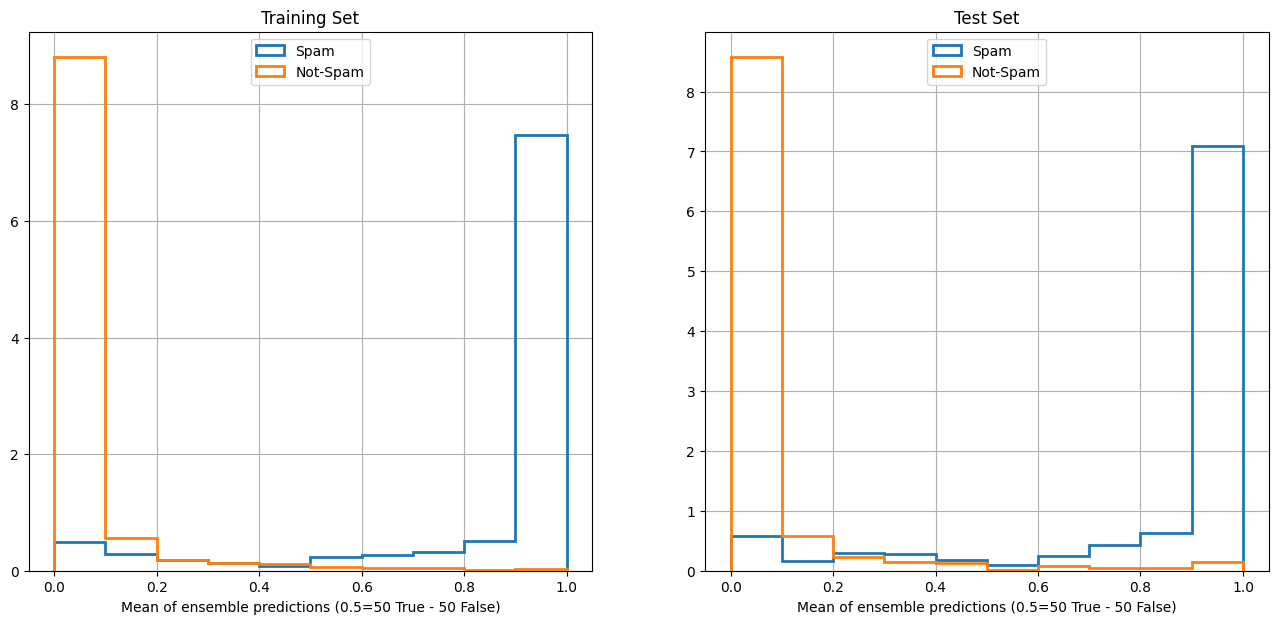

In [52]:
num_to_avg = 100
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for (ax, label, predictions, y) in [
    (axs[0], 'Training Set', predictions_train, y_train), 
    (axs[1], 'Test Set' , predictions_test , y_test ) ]:
    
    # Take the average
    mean_predictions = predictions.iloc[:,:num_to_avg].mean(axis=1)
    
    # Plot the Spam
    mean_predictions[y == 1].hist(density=True, histtype='step', 
                                  range=[0,1], label='Spam', lw=2, ax=ax)
    
    # Plot the non Spam
    mean_predictions[y == 0].hist(density=True, histtype='step', 
                                  range=[0,1], label='Not-Spam', lw=2, ax=ax)
    ax.legend(loc='upper center');
    ax.set_xlabel("Mean of ensemble predictions (0.5=50 True - 50 False)")
    ax.set_title(label)


And now get final predictions: majority voting!

In [53]:
#Function to ensemble the prediction of each bagged decision tree model
def get_prediction(df):
    return np.mean(df, axis=1)>0.5

#Check Accuracy of Spam Detection in Train and Test Set
acc_bagging_training = 100*accuracy_score(y_train, get_prediction(predictions_train))
acc_bagging_testing  = 100*accuracy_score(y_test, get_prediction(predictions_test))

print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))

Bagging: 	Accuracy, Training Set 	: 94.11%
Bagging: 	Accuracy, Testing Set 	: 92.01%


Count in the above code can be use to define the number of models the voting in the dataframe should be based on.

In [54]:
#Get Performance by Class (Lookup Confusion Matrix)
pd.crosstab(np.array(y_test), model.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,All
Actual,,,
0,766,38,804
1,94,441,535
All,860,479,1339



**Food for Thought :** Are these bagging models independent of each other, can they be trained in a parallel fashion?


### ensemble: a group of items viewed as a whole rather than individually


-------------

### Let's talk about decision trees and bagging in the context of bias and variance.
<img src="./bias_variance.png" alt="split2" width="40%"/>
<img src="./fitting.png" alt="split2" width="40%"/>

#### When is a decision tree underfit? When is a decision tree overfit? Let's think about this in the concept of tree depth.

#### Bagging enjoys the benefits of 
- High expressiveness (by using larger trees it is able to approximate complex functions and decision boundaries).
- Low _ _ _  by averaging the prediction of all the models thus reducing the _ _ _  in the final prediction.

#### What is the weakness of bagging?
- In practice, the ensemble of trees tend to be **highly ___**
- When could my bagging model be underfit? In what way does this apply to other ensemble methods?



#### Our Initial Questions:

- What are decision tree models?
- How do we construct them?
- How do we vizualize them?
- What is the idea of bagging?
- Why does bagging help with overfitting?
- Why does bagging help to built more expressive trees?

#### End of Standard Lab. What about next week? 

**Gradient Boosting etc.. building upon decision trees. Why should we care?** 

<img src="./kaggle.png" alt="tree_adj" width="100%"/>


----------
<img src="./trees_adj2.png" alt="tree_adj" width="100%"/>

[Source Medion: "XGBoost Algorithm: Long May She Reign!"](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 2:</strong> Bagging Regressor </div>  

*Let's try to improve our accuracy scores on the cancer dataset.


In [55]:
################################### Train Test split
np.random.seed(40)

#test_proportion
test_prop = 0.2
msk = np.random.uniform(0, 1, len(cancer_scaled)) > test_prop

#Split predictor and response columns
x_train, y_train = cancer_scaled[msk], target[msk]
x_test , y_test  = cancer_scaled[~msk], target[~msk]

print("Shape of Training Set :", x_train.shape)
print("Shape of Testing Set :" , x_test.shape)

Shape of Training Set : (448, 10)
Shape of Testing Set : (121, 10)


## Your tasks:
1) Complete the `get_bagging_scores` function  below.

2) Using `get_bagging_scores` assign a dataframe `bagging_val_acc` using a class instance of `BaggingClassifier`. Try playing with different depths by feeding this object the argument `base_estimator = DecisionTreeClassifier(max_depth = DEPTH)` at initialization. The BaggingClassifier by default takes a `DecisionTreeClassifier`, but it can take other models as well. Try playing with different depths!

3) Use pandas groupby function to to get the mean cross-validation accuracy for specific numbers of estimators. Assign to a new dataframe `bagging_mean_acc`.

4) Visualize the mean cross validation accuracy scores by running the cell provided. Answer the subsequent questions.

In [56]:
type(BaggingClassifier())

sklearn.ensemble._bagging.BaggingClassifier

In [57]:
def get_bagging_df(x_train, y_train, model, bootstrap_range, cv_samples=5):
    """
    This function will take a model and a range of values and return a dataframe with columns: ["depth", "cross_val_acc"]
    
    Arguments:
        model: the model to be run. Specifically this should be a class instance such as
            DecisionTreeClassifier().
        tree_depth_range: the range of values over which the tree depths should be saved.
        
    """
    #write an assert statement that enforces that the model entered is a BaggingClassifier
    assert type(model)== BaggingClassifier

    #declare dictionaries
    mean_CV_acc = {}
    all_CV_acc = {}
    
    #find and store cross_validated scores
    for n_estimators in list(bootstrap_range):
        
        #modify the bagging ensemble models n_estimators (the number of trees it will fit)
        model.n_estimators = n_estimators

        score = cross_val_score(estimator = model, 
                                X = x_train, 
                                y = y_train.reshape(-1), 
                                n_jobs = -1,
                                cv = cv_samples)
        all_CV_acc[n_estimators] = list(score)
        mean_CV_acc[n_estimators] = score.mean() 
    
    #make a dataframe from the dictionary:
    cv_acc_pd = pd.melt(pd.DataFrame(all_CV_acc))
    cv_acc_pd.columns = ["n_estimators", "cv_acc_score"]
    return cv_acc_pd

In [58]:
#you can adjust the ensemble depth. Try to play with different depths!
DEPTH = 10

In [59]:
#your code here: call the repaired get_bagging_scores function.
bagging_val_acc = get_bagging_df(x_train, 
                                y_train, 
                                model = BaggingClassifier(DecisionTreeClassifier(max_depth=DEPTH)),
                                bootstrap_range = range(1, 20),
                                cv_samples = 5
                                )

bagging_mean_acc  = bagging_val_acc.groupby("n_estimators").mean()
print("The best number of trees was found to be:", bagging_mean_acc["cv_acc_score"].idxmax())
print("The best accuracy was found to be:", bagging_mean_acc["cv_acc_score"].max())

The best number of trees was found to be: 19
The best accuracy was found to be: 0.9464918851435705


In [60]:
# %load 'solutions/sol2_bagging.py'

### Run this code when you are finished with the first exercise to compare bagging and the simple decision tree. Final Questions lie below

IndexError: index 19 is out of bounds for axis 0 with size 19

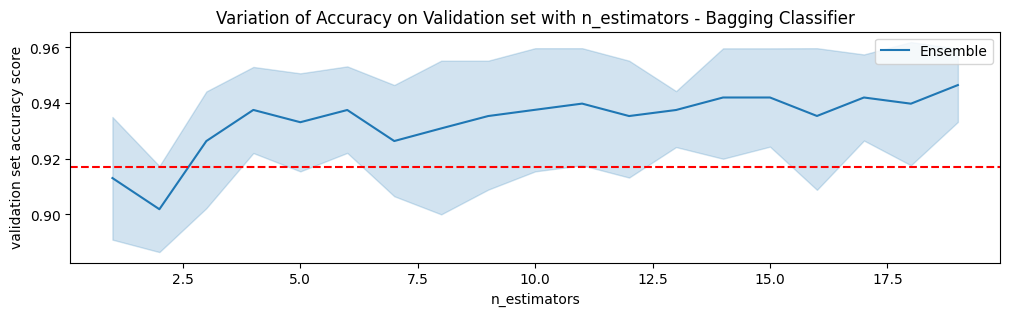

In [62]:
### add a decision tree classifier for comparison.
tree_val_acc = get_tree_scores(x_train, 
                        y_train, 
                        DecisionTreeClassifier(), 
                        tree_depth_range = range(1, 10))

tree_val_acc = pd.melt(pd.DataFrame(tree_val_acc), var_name = "depth", value_name = 'cv_acc_score')

tree_mean_acc  = tree_val_acc.groupby("depth").mean()
best_tree_depth  = tree_mean_acc.index[tree_mean_acc.idxmax()][0]

### Make the plot
plt.figure(figsize=(12, 3))
plt.title('Variation of Accuracy on Validation set with n_estimators - Bagging Classifier')
sns.lineplot(x = "n_estimators", y = "cv_acc_score", data = bagging_val_acc,  
            label = "Ensemble");
plt.axhline(tree_val_acc["cv_acc_score"].mean(), linestyle = '--', color = "red", label = "simple decision tree");

plt.xlabel("n_estimators")
plt.ylabel("validation set accuracy score")

max_idx = tree_mean_acc["cv_acc_score"].idxmax()

best_tree_model = DecisionTreeClassifier(max_depth=best_depth)
best_tree_model.fit(x_train, y_train)
tree_test_accuracy = best_tree_model.score(x_test, y_test.reshape(-1,))

max_idx = bagging_mean_acc["cv_acc_score"].idxmax()
best_n_estimators = bagging_mean_acc.index[max_idx]

best_ensemble_model = BaggingClassifier(n_estimators=best_n_estimators, random_state = 42)
best_ensemble_model.fit(x_train, y_train.reshape(-1,))
ensemble_accuracy = best_ensemble_model.score(x_test, y_test.reshape(-1,))

print("Decision Tree max depth {:}".format(best_depth))
plt.legend()

print("Best Decision Tree test set accuracy:  {:0.2f}%".format(tree_test_accuracy*100))
print("Best Ensemble test set accuracy:  {:0.2f}%".format(ensemble_accuracy*100))


$\bullet$ Why doesn't the bagging accuracy score deteriorate in the same way that the decision tree does for deeper trees?

$\bullet$ Does bagging reduce the variance or the bias of our error? How?

$\bullet$ Bonus question: How do random forests differ from Bagging?